In [60]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math

# Define our buildDataSet function here!

In [61]:
def buildDataSet(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size):
    sparse_data = np.zeros((vector_size, data_set_size), dtype=float)  # Ensure float type
    
    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity, max_sparsity)
        indices = random.sample(range(vector_size), sparsity)
        amps = np.random.uniform(-max_amplitude, max_amplitude, sparsity)  # Use negative and positive values
        sparse_data[indices, i] = amps
    
    # Define the DFT matrix and multiply our sparse_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size) / np.sqrt(vector_size)
    dense_data = DFT @ sparse_data
    
    return dense_data, sparse_data


## Build the dataset

In [62]:
max_amplitude = 100
min_sparsity = 10
max_sparsity = 30
vector_size = 100
data_set_size = 10000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)


## Test the dataset

In [63]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

# Check if the iDFT of the dense data is in fact sparse
print(iDFT@dense_data)


[[ 2.06921490e-13-1.59509968e-13j  1.27605057e-13+8.86441944e-13j
   2.52123147e-13+2.23075629e-13j ... -4.46151334e+01-2.37908649e-13j
   3.40646849e-15-1.30355461e-13j  2.23537398e-13-2.31237185e-13j]
 [-2.61085187e-14-1.74436148e-13j  5.16435776e-13-2.85150889e-14j
   2.60785336e-13+2.56389896e-15j ... -1.41374000e-13-1.70142942e-14j
  -2.29599718e+01-2.98510745e-13j -1.37160566e-13+1.60354310e-13j]
 [-8.34999130e-14+1.59539114e-14j  3.29528429e-13-8.31607519e-13j
   2.38276572e-13-8.97417817e-14j ...  1.45492815e-14-4.17917518e-14j
  -2.94916229e+01-1.87134098e-13j -1.13182010e-13-1.37143881e-13j]
 ...
 [ 1.88192529e-13+3.56942802e-13j -5.07308387e+01+2.80611587e-13j
  -2.03092230e+01-8.99185377e-13j ... -2.76794737e-13+5.94109143e-14j
  -1.87714243e+01+4.59011577e-13j -5.22569439e-14-1.38111143e-13j]
 [-2.10235463e-13+3.13957641e-14j  2.31322532e+01+3.36333216e-14j
   4.03364649e+01+8.43573850e-14j ... -3.12822399e-13+2.65468011e-15j
  -4.44089210e-14+1.03475277e-13j  1.20820838e-

From the above results, we can see that our vectors are very sparse if we take the IDFT

## Setting up the dataset for Pytorch

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init

from sklearn.model_selection import train_test_split

print(dense_data.shape)

X = np.concatenate((dense_data.real,dense_data.imag)).T
Y = np.concatenate((dense_data.real,dense_data.imag)).T

X_tensor = torch.tensor(X,dtype=torch.float)
Y_tensor = torch.tensor(Y,dtype=torch.float)
dataset = TensorDataset(X_tensor,Y_tensor)

dataloader = DataLoader(dataset,batch_size = 500,shuffle = True, )
print(X_tensor.shape)


(100, 10000)
torch.Size([10000, 200])


## Setting up the Neural Networks

In [65]:

def complex_xavier_init(tensor_real, tensor_imag, gain=1.0):
    # Apply Xavier initialization (using uniform variant) to both real and imaginary parts
    init.xavier_uniform_(tensor_real, gain=gain)
    init.xavier_uniform_(tensor_imag, gain=gain)

class ComplexLinearUnitary(nn.Module):
    # This class serves as the encoder layer. We are restricted to values which are of the form e^jq where q are trainable parameters
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long
    def __init__(self,input_dim,output_dim):
        super(ComplexLinearUnitary,self).__init__()
        # Here we create the q-values of our unitary matrix. These are the parameters we are training such that each entry of our complex matrix to encode our data is |F_ij| = 1
        self.q_values = nn.Parameter(torch.randn(output_dim,input_dim))

    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = torch.cos(self.q_values)
        W_imag = torch.sin(self.q_values)
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out
    
class ComplexLinear(nn.Module):
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long. This gets fixed because we make the matrix
    # W_total which multiplies [x_real;x_imag] and returns [y_real;y_imag]
    def __init__(self,input_dim,output_dim):
        super(ComplexLinear,self).__init__()
        # Here we create the complex matrix W
        #self.W_real = nn.Parameter(torch.randn(output_dim,input_dim))# eye(input_dim))
        #self.W_imag = nn.Parameter(torch.randn(output_dim,input_dim)) #zeros((input_dim,output_dim)))

        self.W_real = nn.Parameter(torch.empty(output_dim, input_dim))
        self.W_imag = nn.Parameter(torch.empty(output_dim, input_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize both the real and imaginary parts using Xavier initialization.
        complex_xavier_init(self.W_real, self.W_imag)
        
    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = self.W_real
        W_imag = self.W_imag
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out

class FeedthroughEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(FeedthroughEncoder, self).__init__()
        """ compression_factor = input_dim / encoding_dim
        layer_size_factor = int(encoding_dim * compression_factor / 4) """

        self.encoder = ComplexLinear(input_dim,encoding_dim)

        self.decoder = nn.Sequential(
            ComplexLinear(encoding_dim,input_dim)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out)


class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()

        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)

        return self.decoder(encoder_out)
    
class LearnedAutoencoderWithNoise(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance):
        super(LearnedAutoencoderWithNoise, self).__init__()
        self.variance = variance
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise = torch.tensor(noise_np,dtype=torch.float)
        noisy_y = encoder_out + noise
        return self.decoder(noisy_y)


class LearnedAutoencoderWithIQImbalance(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,b, d,variance):
        super(LearnedAutoencoderWithIQImbalance, self).__init__()
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance = variance
        self.r = torch.tensor(0.5*(1+b*np.exp(1j*d)), dtype=torch.complex64)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        y_real = encoder_out[:, :self.encoding_dim]
        y_imag = encoder_out[:, self.encoding_dim:]
        y = torch.complex(y_real,y_imag)
        yiq = self.r * y + (1-self.r.conj()) * (y.conj())
        yiqr = yiq.real
        yiqi = yiq.imag
        yiqstack = torch.cat((yiqr,yiqi),dim=1)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise_tensor = torch.tensor(noise_np,dtype=torch.float)
        y_iq_stack_noisy = yiqstack + noise_tensor
        return self.decoder(y_iq_stack_noisy)


#### Training the feedthrough model

Epoch 1, Loss: 109.331810
Epoch 2, Loss: 24.744257
Epoch 3, Loss: 6.127776
Epoch 4, Loss: 1.336755
Epoch 5, Loss: 0.157012
Epoch 6, Loss: 0.022803
Epoch 7, Loss: 0.003501
Epoch 8, Loss: 0.000536
Epoch 9, Loss: 0.000078
Epoch 10, Loss: 0.000013
Epoch 11, Loss: 0.000002
Epoch 12, Loss: 0.000000
Epoch 13, Loss: 0.000000
Epoch 14, Loss: 0.000000
Epoch 15, Loss: 0.000000
Epoch 16, Loss: 0.000000
Epoch 17, Loss: 0.000000
Epoch 18, Loss: 0.000000
Epoch 19, Loss: 0.000000
Epoch 20, Loss: 0.000000


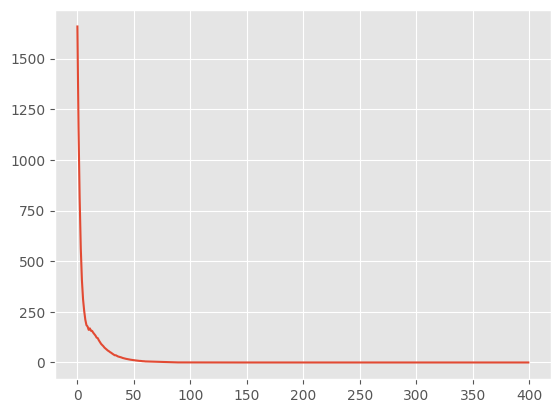

In [66]:
# Define the size of our "measurement" vector as encoding_dim. This needs to be larger than the sparsity of our matrix

# encoding_dim = max_sparsity
# encoding_dim = 100
# vector_size = 100
encoding_dim = vector_size
# Initialize model
feedthrough_model = FeedthroughEncoder(vector_size, encoding_dim)
optimizer = torch.optim.Adam(feedthrough_model.parameters(), lr=1E-2, weight_decay=1E-6)
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(20):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = feedthrough_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()


#### Train the AutoEncoder Model

Epoch 1, Loss: 336.476471
Epoch 2, Loss: 316.607788
Epoch 3, Loss: 313.782745
Epoch 4, Loss: 278.011719
Epoch 5, Loss: 238.217514
Epoch 6, Loss: 214.640793
Epoch 7, Loss: 194.585052
Epoch 8, Loss: 173.966980
Epoch 9, Loss: 166.998886
Epoch 10, Loss: 158.509674
Epoch 11, Loss: 146.333694
Epoch 12, Loss: 143.402466
Epoch 13, Loss: 136.895477
Epoch 14, Loss: 131.747787
Epoch 15, Loss: 128.227600
Epoch 16, Loss: 124.486702
Epoch 17, Loss: 118.312157
Epoch 18, Loss: 115.639587
Epoch 19, Loss: 114.100853
Epoch 20, Loss: 114.100853
Epoch 21, Loss: 107.478394
Epoch 22, Loss: 107.478394
Epoch 23, Loss: 105.620911
Epoch 24, Loss: 105.620911
Epoch 25, Loss: 104.477501
Epoch 26, Loss: 104.477501
Epoch 27, Loss: 99.675888
Epoch 28, Loss: 99.675888
Epoch 29, Loss: 99.675888
Epoch 30, Loss: 99.675888
Epoch 31, Loss: 99.675888
Epoch 32, Loss: 95.231308
Epoch 33, Loss: 93.695236
Epoch 34, Loss: 92.928757
Epoch 35, Loss: 92.612877
Epoch 36, Loss: 91.710228
Epoch 37, Loss: 91.710228
Epoch 38, Loss: 90.77

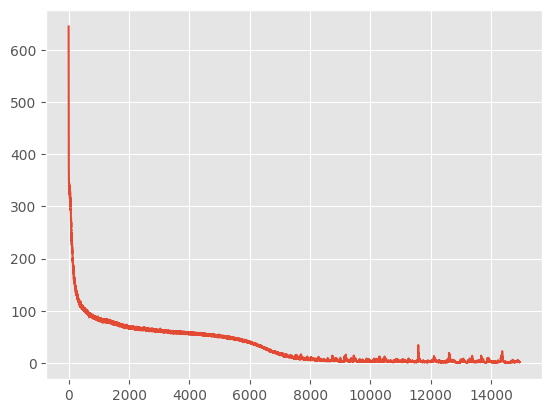

In [67]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.95
# Beta_variance: 0.99
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5

encoding_dim = 50

# Initialize model
hidden_dims = np.array([60,80])
learned_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(learned_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = learned_autoencoder_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss < lowest_loss:
        lowest_loss = loss.item()
        early_stopping_counter = 0
        best_model = learned_autoencoder_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            learned_autoencoder_model = best_model
            print(f"stopped early after {epoch+1} epochs, with a loss of: {lowest_loss}")
            break

    print(f"Epoch {epoch+1}, Loss: {lowest_loss:.6f}")

plt.plot(losses)
plt.show()


Some conclusions that we have found so far:
- Batch size must be minimally greater than 100. 500 seems to work well.
- 2 hidden layers of size 50,70 leads to a loss of 0.3 MSE
- Decreasing variance below 0.999 does not seem to have a positive effect


## Train Noisy Models

In [68]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.9
# Beta_variance: 0.999
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5
# variance = 1
noisy_models = []
noisy_losses = []

# We define our signal to noise ratio as ranging from 0 to 20 dB
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

for db,abs in SNR.items():
    encoding_dim = 50
    variance = signal_variance/abs
    # Initialize model
    hidden_dims = np.array([60,80])
    noisy_autoencoder_model = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
    optimizer = torch.optim.Adam(noisy_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()
# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)
    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(1):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = noisy_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            early_stopping_counter = 0
            best_model = noisy_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                noisy_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss {lowest_loss:.6f}")
                break

        print(f"SNR Ratio: {db}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    noisy_models.append(best_model)
    noisy_losses.append(lowest_loss)

# plt.plot(losses)
# plt.show()(noisy_losses


SNR Ratio: 2, Epoch 1, Loss: 341.248840
SNR Ratio: 5, Epoch 1, Loss: 337.058746
SNR Ratio: 8, Epoch 1, Loss: 334.235413
SNR Ratio: 11, Epoch 1, Loss: 334.010071
SNR Ratio: 14, Epoch 1, Loss: 330.536255
SNR Ratio: 17, Epoch 1, Loss: 326.934052
SNR Ratio: 20, Epoch 1, Loss: 328.686493


# Save the Noisy Models

In [69]:
for indx, (db, value) in enumerate(SNR.items()):
    torch.save(noisy_models[indx].state_dict(), f"noisy_model_{db}_{min_sparsity}-{max_sparsity}.pt")


## Initialize pre-trained noiseless model

In [70]:
# Instantiate your model architecture first
encoding_dim = 50
vector_size = 100
hidden_dims = np.array([50,70])
pretrained_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
pretrained_model.load_state_dict(torch.load("model_state_hidden_layers_50_70.pt"))

pretrained_model.eval()  # Set the model to evaluation mode if needed


LearnedAutoencoder(
  (encoder): ComplexLinearUnitary()
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=140, bias=True)
    (3): ReLU()
    (4): Linear(in_features=140, out_features=200, bias=True)
  )
)

## Show the output for a given sparse input vector



In [71]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output
h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

H_hat = pretrained_model(H_tensor)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))


/tmp/ipykernel_7279/3254949652.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())


/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


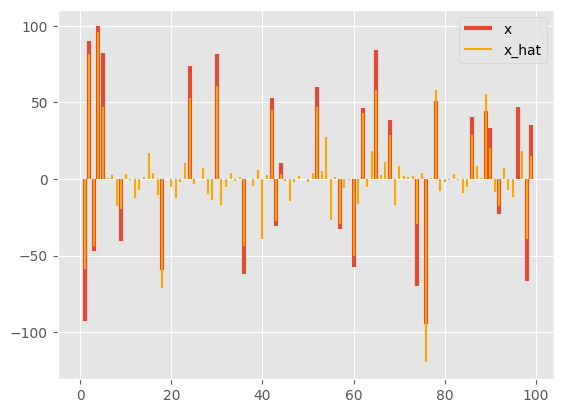

In [72]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))


## Extract the encoding matrix, generate a (noisy) y and use the decoder to find $\hat{h}$, then plot $\hat{x}$

In [73]:
# Load the autoencoder

encoding_dim = 50
vector_size = 100
hidden_dims = np.array([60,80])
variance = 10
noisy_autoencoder = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
noisy_autoencoder.load_state_dict(torch.load("noisy_autoencoder_10var_60_80.pt",))
noisy_autoencoder.eval()

# Build the W matrix
q_values = noisy_autoencoder_model.encoder.q_values

W_real = torch.cos(q_values)
W_imag = torch.sin(q_values)
W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 

# Build the input vector

h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

y = torch.matmul(H_tensor,W_total.T)

# Make the noise

variance = 10

noise_np = np.random.normal(0,variance,size=100)
noise = torch.tensor(noise_np,dtype=torch.float)
noisy_y = y + noise

# Rebuild h, and x from the noisy y using the decoder

H_hat = noisy_autoencoder_model.decoder(noisy_y)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

x_hat = iDFT@h_hat
indices = range(len(x_hat))


/tmp/ipykernel_7279/1086048979.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())


## Plotting

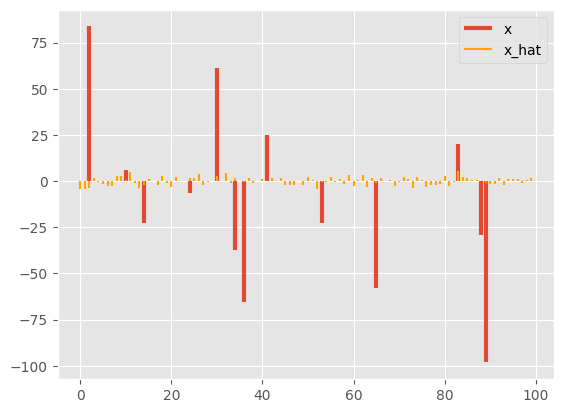

In [74]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))


## Show the weights

In [75]:
# THIS DOESN'T WORK. TO BE FIXED

for idx, layer in enumerate(pretrained_model.decoder):
    # Check if the layer is an instance of ComplexLinear
    if isinstance(layer, nn.Linear):
        print(f"Decoder layer {idx} (ComplexLinear) W_real:")
        print(layer.weight)
        print(f"Decoder layer {idx} (ComplexLinear) W_imag:")
        print(layer.weight)


Decoder layer 0 (ComplexLinear) W_real:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  0.0210,  0.0204]],
       requires_grad=True)
Decoder layer 0 (ComplexLinear) W_imag:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  

In [93]:
imbalance_levels = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}

# Calculate the dB imbalance levels, we store them in the dictionary IRR_ratios such that we can extract it with the corresponding level imbalance
for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)



/tmp/ipykernel_7279/3681228875.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


In [95]:
# Looping over 
for level, db_ratio in IRR_ratios.items():
    encoding_dim = 50
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    variance = 0
    # Initialize model
    hidden_dims = np.array([60,80])
    imbalanced_autoencoder_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    optimizer = torch.optim.Adam(imbalanced_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()

    # def complex_mse_loss(input, target):
    #     return F.mse_loss(input, target)

    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = imbalanced_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = imbalanced_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                imbalanced_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                break
        print(f"IRR Ratio:{db_ratio}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    imbalanced_models.append(best_model)
    imbalanced_losses.append(lowest_loss)

# plt.plot(losses)
# plt.show()


IRR Ratio:inf, Epoch 1, Loss: 333.789307
IRR Ratio:inf, Epoch 2, Loss: 324.582397
IRR Ratio:inf, Epoch 3, Loss: 315.376709
IRR Ratio:inf, Epoch 4, Loss: 295.905518
IRR Ratio:inf, Epoch 5, Loss: 259.772217
IRR Ratio:inf, Epoch 6, Loss: 238.346878
IRR Ratio:inf, Epoch 7, Loss: 207.468964
IRR Ratio:inf, Epoch 8, Loss: 188.123123
IRR Ratio:inf, Epoch 9, Loss: 177.880417
IRR Ratio:inf, Epoch 10, Loss: 170.624084
IRR Ratio:inf, Epoch 11, Loss: 162.864227
IRR Ratio:inf, Epoch 12, Loss: 144.542007
IRR Ratio:inf, Epoch 13, Loss: 141.888626
IRR Ratio:inf, Epoch 14, Loss: 136.097641
IRR Ratio:inf, Epoch 15, Loss: 135.182953
IRR Ratio:inf, Epoch 16, Loss: 126.540977
IRR Ratio:inf, Epoch 17, Loss: 126.511642
IRR Ratio:inf, Epoch 18, Loss: 123.623062
IRR Ratio:inf, Epoch 19, Loss: 117.018600
IRR Ratio:inf, Epoch 20, Loss: 117.539337
IRR Ratio:inf, Epoch 21, Loss: 114.677063
IRR Ratio:inf, Epoch 22, Loss: 109.889717
IRR Ratio:inf, Epoch 23, Loss: 109.506264
IRR Ratio:inf, Epoch 24, Loss: 107.553062
I

# Train the IQ Imbalance model

In [82]:

imbalance_levels = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}

# Calculate the dB imbalance levels, we store them in the dictionary IRR_ratios such that we can extract it with the corresponding level imbalance
for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)


/tmp/ipykernel_7279/2421521896.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


# Save the IQ-Imbalance Models


In [96]:
for indx, items in enumerate(IRR_ratios):
    torch.save(imbalanced_models[indx].state_dict(), f"imbalanced_model_{items:.3f}_{min_sparsity}-{max_sparsity}.pt")


# Train various measurement matrix size

In [97]:
measurement_sizes = [5, 10, 20, 30, 40, 50]
measurement_models = []
measurement_losses = []

for encoding_dim in measurement_sizes:
    level = 0.6 # Set the IQ imbalance level to around 33 dB IRR
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    variance = signal_variance/SNR[17] # Set the SNR to 17 dB
    # Initialize model
    hidden_dims = np.array([60,80])
    measurement_autoencoder_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    optimizer = torch.optim.Adam(measurement_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()

    # def complex_mse_loss(input, target):
    #     return F.mse_loss(input, target)

    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = measurement_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = measurement_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                measurement_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                break
        print(f"Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    measurement_models.append(best_model)
    measurement_losses.append(lowest_loss)


Encoding dimension:5, Epoch 1, Loss: 342.898163
Encoding dimension:5, Epoch 2, Loss: 333.303131
Encoding dimension:5, Epoch 3, Loss: 321.463318
Encoding dimension:5, Epoch 4, Loss: 313.634186
Encoding dimension:5, Epoch 5, Loss: 316.763824
Encoding dimension:5, Epoch 6, Loss: 298.046387
Encoding dimension:5, Epoch 7, Loss: 298.433838
Encoding dimension:5, Epoch 8, Loss: 302.387177
Encoding dimension:5, Epoch 9, Loss: 299.592865
Encoding dimension:5, Epoch 10, Loss: 311.491364
Encoding dimension:5, Epoch 11, Loss: 290.830841
Encoding dimension:5, Epoch 12, Loss: 305.597961
Encoding dimension:5, Epoch 13, Loss: 296.979828
Encoding dimension:5, Epoch 14, Loss: 298.581024
Encoding dimension:5, Epoch 15, Loss: 300.025391
Encoding dimension:5, Epoch 16, Loss: 297.160828
Encoding dimension:5, Epoch 17, Loss: 293.307190
Encoding dimension:5, Epoch 18, Loss: 293.762665
Encoding dimension:5, Epoch 19, Loss: 304.820251
Encoding dimension:5, Epoch 20, Loss: 305.238037
Encoding dimension:5, Epoch 2

# Save the measurement models

In [98]:
measurement_sizes = [5, 10, 20, 30, 40, 50]
for indx, encoding_dim in enumerate(measurement_sizes):
    torch.save(measurement_models[indx].state_dict(), f"measurement_model_{encoding_dim}_{min_sparsity}-{max_sparsity}.pt")


# Plotting

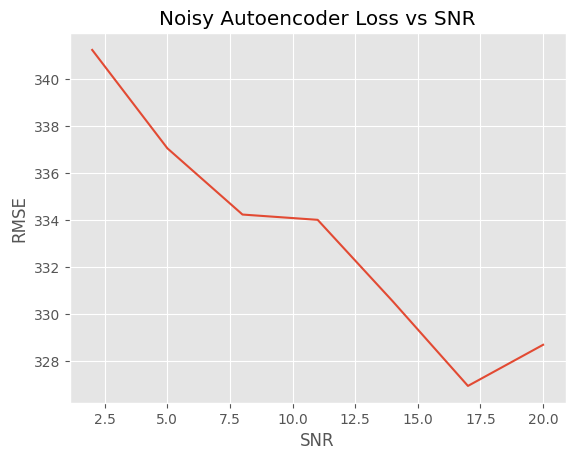

In [99]:
plt.rcParams['text.usetex'] = False
SNRkeys = SNR.keys()
plt.plot(SNRkeys, noisy_losses)
plt.title("Noisy Autoencoder Loss vs SNR")
plt.xlabel("SNR")
plt.ylabel("RMSE")
plt.show()


[np.float64(inf), np.float64(41.08929220065852), np.float64(33.118820471594574), np.float64(23.531709031336195), np.float64(17.42758855859956), np.float64(12.849459258668094)]
[tensor(0.4475), tensor(0.4952), tensor(0.7048), tensor(0.4662), tensor(0.2950), tensor(0.6773)]
6


/tmp/ipykernel_7279/3275395742.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


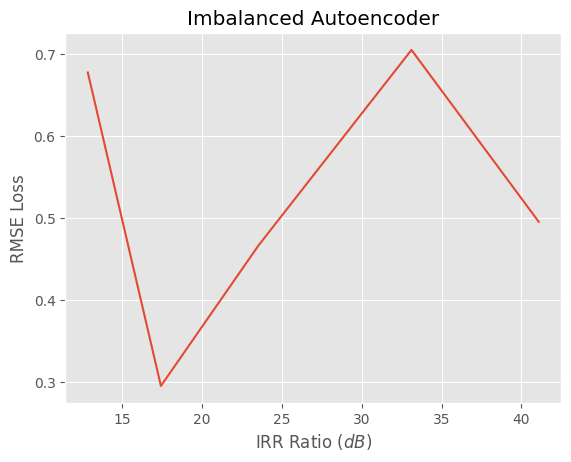

In [100]:
imbalanced_losses_np = []
for loss in imbalanced_losses:
    imbalanced_losses_np.append(torch.Tensor.detach(loss))

db_IRR_ratios = []

for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)
    db_IRR_ratios.append(10*np.log10(IRR_ratio))

print(db_IRR_ratios)
print(imbalanced_losses_np)
print(len(db_IRR_ratios))
plt.figure()
plt.plot(db_IRR_ratios, imbalanced_losses_np)
plt.title("Imbalanced Autoencoder")
plt.xlabel("IRR Ratio ($dB$)")
plt.ylabel("RMSE Loss")
plt.show()


In [101]:
# Test IQ Imbalance model

# Generate a vector
h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T


H_tensor = torch.tensor(H,dtype=torch.float)

imbalanced_autoencoder_model(H_tensor)


tensor([[-1.3453e+01, -2.0031e+01,  7.9123e+00,  4.2281e+00, -2.2793e+01,
         -2.7591e+01, -1.2002e+01,  2.8659e+01,  3.2376e+00, -2.1363e+01,
         -1.4428e+01, -3.9872e+00,  2.0787e+01,  4.7836e+00, -7.5532e+00,
         -8.7499e+00,  1.0626e+01, -8.0869e-01,  3.5495e+01,  1.5982e+00,
         -8.2320e+00,  1.0252e+01, -6.6791e+00,  4.6971e-01,  1.2820e+01,
          5.0346e+01, -2.6502e+01, -2.5506e+00,  1.2347e+00, -3.0631e+01,
          5.4843e+00,  2.5185e+01,  1.7818e+01, -1.4981e+01,  1.0161e+00,
         -3.7106e+01, -1.5676e+01,  6.0125e+00,  2.8835e+01,  1.0057e+01,
         -2.3166e+01, -2.2927e+01,  1.7129e+00,  8.4173e+00, -3.0229e+01,
          1.1130e+01, -2.6893e+00, -9.9904e+00,  4.2175e+01, -9.1336e+00,
         -5.1959e+01, -9.1017e+00,  4.2146e+01, -9.9873e+00, -2.6517e+00,
          1.1179e+01, -3.0275e+01,  8.4417e+00,  1.7134e+00, -2.2987e+01,
         -2.3139e+01,  1.0065e+01,  2.8874e+01,  6.0223e+00, -1.5700e+01,
         -3.7071e+01,  1.0028e+00, -1.

# Generate new dataset, initialize pretrained models, evaluate the loss and plot

In [102]:
noisy_pretrained_models = {}
imbalanced_pretrained_models = {}
measurement_pretrained_models = {}

# Define the SNR dictionary for use
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

#Initialize pretrained noisy models
for db,abs in SNR.items():
    encoding_dim = 50
    variance = signal_variance/abs
    # Initialize model
    hidden_dims = np.array([60,80])
    noisy_pretrained_models[db] = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
    noisy_pretrained_models[db].load_state_dict(torch.load(f"noisy_model_{db}.pt", weights_only=True))

# Initialize pretrained imbalanced models
for level, db  in IRR_ratios.items():
    encoding_dim = 50
    variance = 0
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    # Initialize model
    hidden_dims = np.array([60,80])
    imbalanced_pretrained_models[level] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    imbalanced_pretrained_models[level].load_state_dict(torch.load(f"imbalanced_model_{db:.3f}.pt", weights_only=True))

# Initialize pretrained imbalanced models
for encoding_dim  in measurement_sizes:
    variance = signal_variance/SNR[17]
    level = 0.6
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    # Initialize model
    hidden_dims = np.array([60,80])
    measurement_pretrained_models[encoding_dim] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    measurement_pretrained_models[encoding_dim].load_state_dict(torch.load(f"measurement_model_{encoding_dim}.pt", weights_only=True))


In [103]:
# Generate dataset
max_amplitude = 100
min_sparsity = 3
max_sparsity = 5
vector_size = 100
data_set_size = 10000
val_dense_data, val_sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

print(val_sparse_data[0,:])

X_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T
Y_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T

X_val_tensor = torch.tensor(X_val,dtype=torch.float)
Y_val_tensor = torch.tensor(Y_val,dtype=torch.float)
val_dataset = TensorDataset(X_val_tensor,Y_val_tensor)

dataloader_val = DataLoader(val_dataset,batch_size = 500,shuffle = True, )

loss_fn = nn.MSELoss()


[0. 0. 0. ... 0. 0. 0.]


In [104]:

# Validating the noisy models
noisy_val_losses = []
noisy_model_losses = []

with torch.no_grad():
    for db, noisy_model in noisy_pretrained_models.items():
        noisy_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = noisy_model(inputs)
            loss = loss_fn(output, targets)
            noisy_model_losses.append(loss.item())
        noisy_val_losses.append(np.average(noisy_model_losses))
        noisy_model_losses = []

noisy_val_losses = np.array(noisy_val_losses)
normalized_noisy_val_losses = noisy_val_losses/signal_variance
print(noisy_val_losses)


[33.65499744 16.77318301  4.7130971   5.10751626  4.31025512  4.00099216
  3.55591129]


In [105]:
# Validating the IQ imbalance models
imbalance_model_losses = []
imbalance_val_losses = []

with torch.no_grad():
    for level, imbalance_model in imbalanced_pretrained_models.items():
        imbalance_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = noisy_model(inputs)
            loss = loss_fn(output, targets)
            imbalance_model_losses.append(loss.item())
        imbalance_val_losses.append(np.average(imbalance_model_losses))
        imbalance_model_losses = []

imbalance_val_losses = np.array(imbalance_val_losses)
normalized_imbalance_val_losses = imbalance_val_losses/signal_variance
print(imbalance_val_losses)


[3.53381242 3.55942123 3.55118189 3.5401282  3.5314608  3.55570451]


In [106]:
# Validating the varying measurement dimensions models
measurement_model_losses = []
measurement_val_losses = []

with torch.no_grad():
    for encoding_dim, measurement_model in measurement_pretrained_models.items():
        measurement_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = measurement_model(inputs)
            loss = loss_fn(output, targets)
            measurement_model_losses.append(loss.item())
        measurement_val_losses.append(np.average(measurement_model_losses))
        print(f"Encoding dimenson:{encoding_dim} Losses:{measurement_model_losses}")
        measurement_model_losses = []

measurement_val_losses = np.array(measurement_val_losses)
normalized_measurement_val_losses = measurement_val_losses/signal_variance


Encoding dimenson:5 Losses:[46.25954055786133, 48.325889587402344, 52.74267578125, 49.462318420410156, 50.979183197021484, 46.750083923339844, 49.602596282958984, 50.576904296875, 50.84278106689453, 53.54391098022461, 47.52950668334961, 51.22171401977539, 49.71331024169922, 47.84151077270508, 49.28028106689453, 49.966819763183594, 50.90019989013672, 49.03290939331055, 50.89434051513672, 46.68193817138672]
Encoding dimenson:10 Losses:[38.381839752197266, 37.92005920410156, 38.36772537231445, 39.38131332397461, 33.73322296142578, 37.17689514160156, 39.725711822509766, 39.916988372802734, 38.19814682006836, 39.33805465698242, 37.06045913696289, 37.99136734008789, 38.52098083496094, 36.147178649902344, 37.15088653564453, 39.231632232666016, 36.773956298828125, 38.6686897277832, 36.628353118896484, 39.4175910949707]
Encoding dimenson:20 Losses:[18.871322631835938, 17.630481719970703, 19.657604217529297, 17.88982582092285, 16.801156997680664, 17.615713119506836, 18.486520767211914, 16.755147

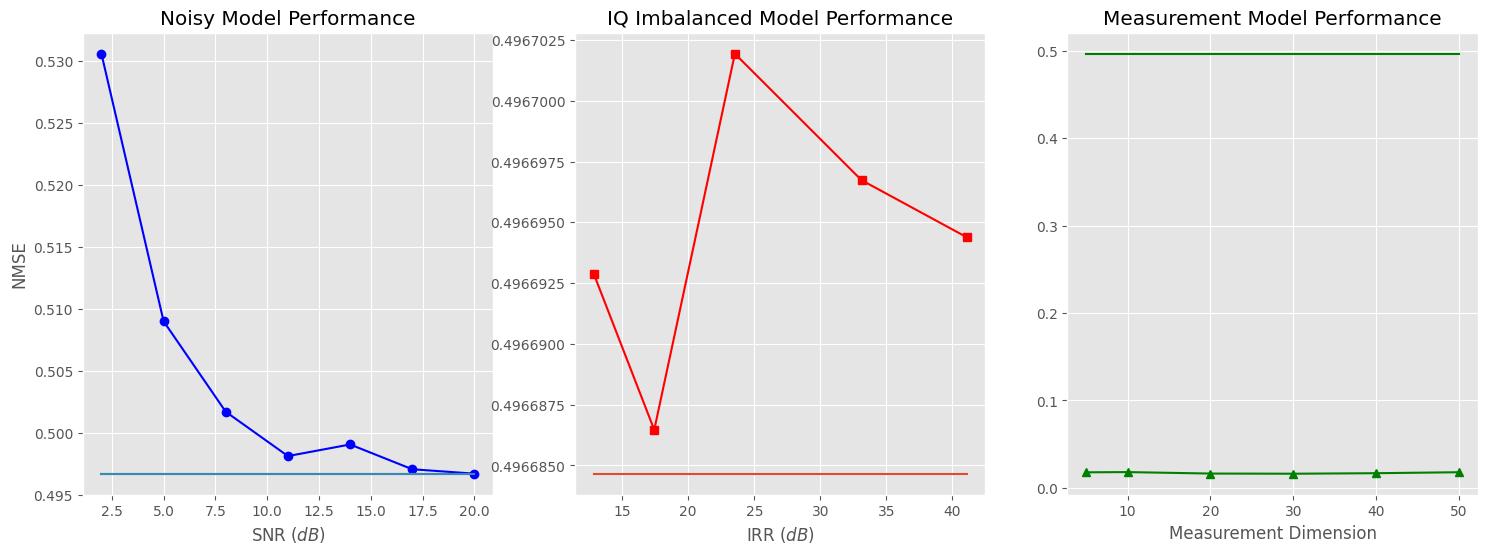

In [163]:
noiseless_loss = normalized_imbalance_val_losses[0]

plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))
ax1.plot(SNR.keys(),normalized_noisy_val_losses,color= "blue", marker="o")
ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
ax1.set_xlabel("SNR $(dB)$")
ax1.set_ylabel("NMSE")
ax1.set_title("Noisy Model Performance")
ax1.grid(True)

ax2.plot(IRR_ratios.values(),normalized_imbalance_val_losses,color= 'red',marker='s')
ax2.plot(IRR_ratios.values(), [noiseless_loss for i in IRR_ratios.values()])
ax2.set_xlabel("IRR $(dB)$")
ax2.set_title("IQ Imbalanced Model Performance")

ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
ax2.grid(True)

ax3.plot(measurement_sizes,normalized_measurement_val_losses,color= 'green',marker='^')
ax3.plot(measurement_sizes, [noiseless_loss for i in measurement_sizes], color='green')
ax3.set_xlabel("Measurement Dimension")
ax3.set_title("Measurement Model Performance")
ax3.grid(True)


In [140]:
sparsity_ranges = [(3, 5), (5, 7), (7, 9), (10, 30)]

# Define the SNR dictionary for use
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

#empty dicts to store models in
noisy_pretrained_models = {}
imbalanced_pretrained_models = {}
measurement_pretrained_models = {}

for i, (min_spars, max_spars) in enumerate(sparsity_ranges):

    #Initialize pretrained noisy models
    for db,abs in SNR.items():
        encoding_dim = 50
        variance = signal_variance/abs
        # Initialize model
        hidden_dims = np.array([60,80])
        noisy_pretrained_models[(i, db)] = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
        noisy_pretrained_models[(i, db)].load_state_dict(torch.load(f"noisy_model_{db}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained imbalanced models
    for level, db  in IRR_ratios.items():
        encoding_dim = 50
        variance = 0
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        imbalanced_pretrained_models[(i, level)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        imbalanced_pretrained_models[(i, level)].load_state_dict(torch.load(f"imbalanced_model_{level:.3f}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained measurement models
    for encoding_dim  in measurement_sizes:
        variance = signal_variance/SNR[17]
        level = 0.6
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        measurement_pretrained_models[(i, encoding_dim)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        measurement_pretrained_models[(i, encoding_dim)].load_state_dict(torch.load(f"measurement_model_{encoding_dim}_{min_spars}-{max_spars}.pt", weights_only=True))


In [173]:
# Generate dataset
def Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size):
    for i, (min_spars, max_spars) in enumerate(sparsity_ranges):
        val_dense_data, val_sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

        X_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T
        Y_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T

        X_val_tensor = torch.tensor(X_val,dtype=torch.float)
        Y_val_tensor = torch.tensor(Y_val,dtype=torch.float)
        val_dataset = TensorDataset(X_val_tensor,Y_val_tensor)

        dataloader_val = DataLoader(val_dataset,batch_size = 500,shuffle = True, )
        variance = np.var(Y_val)
    return dataloader_val, variance


In [183]:
all_noisy_losses = []
all_imbalanced_losses = []
all_measurement_losses = []


for min_spars, max_spars in sparsity_ranges:
    dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_spars, max_spars, vector_size, data_set_size)
    # Evaluate noisy models
    noisy_val_losses = []
    noisy_model_losses = []
    with torch.no_grad():
        for db, abs in SNR.items():
            noisy_model = noisy_pretrained_models[(i, db)]
            noisy_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = noisy_model(inputs)
                loss = loss_fn(output, targets)
                noisy_model_losses.append(loss.item())
            noisy_val_losses.append(np.average(noisy_model_losses))
            noisy_model_losses = []

    noisy_val_losses = np.array(noisy_val_losses)
    normalized_noisy_val_losses = noisy_val_losses/signal_variance
    all_noisy_losses.append(normalized_noisy_val_losses)

    # Evaluate Imbalanced models
    imbalance_model_losses = []
    imbalance_val_losses = []

    with torch.no_grad():
        for level, db in IRR_ratios.items():
            imbalance_model = imbalanced_pretrained_models[(i, level)]
            imbalance_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = noisy_model(inputs)
                loss = loss_fn(output, targets)
                imbalance_model_losses.append(loss.item())
            imbalance_val_losses.append(np.average(imbalance_model_losses))
            imbalance_model_losses = []

    imbalance_val_losses = np.array(imbalance_val_losses)
    normalized_imbalance_val_losses = imbalance_val_losses/signal_variance
    all_imbalanced_losses.append(normalized_imbalance_val_losses)

    # Evaluate models with varying measurement sizes
    measurement_model_losses = []
    measurement_val_losses = []

    with (torch.no_grad()):
        for encoding_dim in measurement_sizes:
            mesaurement_model = measurement_pretrained_models[(i, encoding_dim)]
            measurement_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = measurement_model(inputs)
                loss = loss_fn(output, targets)
                measurement_model_losses.append(loss.item())
            measurement_val_losses.append(np.average(measurement_model_losses))
            measurement_model_losses = []

    measurement_val_losses = np.array(measurement_val_losses)
    normalized_measurement_val_losses = measurement_val_losses#/signal_variance
    all_measurement_losses.append(normalized_measurement_val_losses)


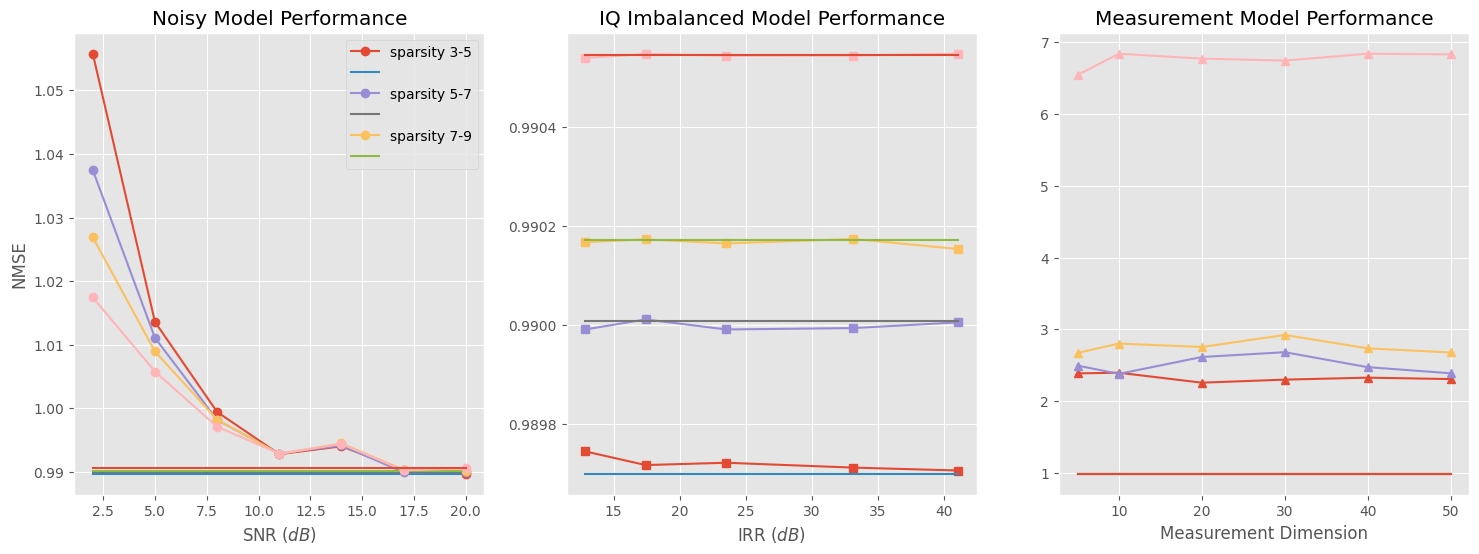

In [184]:
plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))

for i in range(4):
    noiseless_loss = all_imbalanced_losses[i][0]

    ax1.plot(SNR.keys(), all_noisy_losses[i], marker="o")
    ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
    ax1.set_xlabel("SNR $(dB)$")
    ax1.set_ylabel("NMSE")
    ax1.set_title("Noisy Model Performance")
    ax1.grid(True)
    ax1.legend(["sparsity 3-5","", "sparsity 5-7","", "sparsity 7-9",""])

    ax2.plot(IRR_ratios.values(),all_imbalanced_losses[i],marker='s')
    ax2.plot(IRR_ratios.values(), [noiseless_loss for i in IRR_ratios.values()])
    ax2.set_xlabel("IRR $(dB)$")
    ax2.set_title("IQ Imbalanced Model Performance")
    ax1.legend(["sparsity 3-5","", "sparsity 5-7","", "sparsity 7-9",""])
    ax2.grid(True)

    ax3.plot(measurement_sizes, all_measurement_losses[i],marker='^')
    ax3.plot(measurement_sizes, [noiseless_loss for i in measurement_sizes])
    ax3.set_xlabel("Measurement Dimension")
    ax3.set_title("Measurement Model Performance")
    ax1.legend(["sparsity 3-5","", "sparsity 5-7","", "sparsity 7-9",""])
    ax3.grid(True)